In [1]:
import torch
import logging
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, AdamW
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from scripts.data_processing import *

In [2]:
# Check and print whether CUDA is available, the version of PyTorch, and the GPU name (if available)
# This section will display:

# - Whether CUDA is available on the system
print("CUDA available:", torch.cuda.is_available())
# - The version of PyTorch installed
print("PyTorch version:", torch.__version__)
# - The name of the GPU being used (if CUDA is available)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
PyTorch version: 2.5.1+cu118
GPU: NVIDIA GeForce RTX 4070 Ti


In [3]:
# Set logging level to ERROR to suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

In [4]:
# Load the saved data
data = torch.load('data/preprocessed_data.pth')

# Extract training and testing data from the 'data' dictionary
train_inputs = data['train_inputs']
train_labels = data['train_labels']
test_inputs = data['test_inputs']
test_labels = data['test_labels']

C:\Users\Anastasiia\AppData\Local\Temp\ipykernel_23452\1161382290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data/preprocessed_data.pth')


In [5]:
# Define label-to-ID mapping
label2id = {"O": 0, "B-MOUNT": 1, "I-MOUNT": 2}

# Recreate the datasets
train_dataset = NERDataset(train_inputs, train_labels, label2id)
test_dataset = NERDataset(test_inputs, test_labels, label2id)

# Recreate the DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [6]:
# Define the model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=3,
    id2label={0: "O", 1: "B-MOUNT", 2: "I-MOUNT"},
    label2id={"O": 0, "B-MOUNT": 1, "I-MOUNT": 2}
)

# Set the device to GPU if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Define class weights for imbalanced data
tag_counts = {'O': 10153, 'B-MOUNT': 82, 'I-MOUNT': 5}
total = sum(tag_counts.values())
weights = torch.tensor([
    total / tag_counts['O'],          # Weight for "O"
    total / tag_counts['B-MOUNT'],    # Weight for "B-MOUNT"
    total / tag_counts['I-MOUNT'],    # Weight for "I-MOUNT"
]).to(device)

# Use weighted loss
loss_function = CrossEntropyLoss(weight=weights)

# Prepare optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Move model to device (GPU if available)
model.to(device)

c:\Users\Anastasiia\anaconda3\envs\Quantum-NER\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [8]:
# List to store loss for each epoch
epoch_num = 50

# List to store loss for each epoch
epoch_losses = []

# Total number of batches for all epochs
total_batches = len(train_dataloader) * epoch_num

# Global progress bar
with tqdm(total=total_batches, desc="Training Progress") as pbar:
    model.train()
    for epoch in range(epoch_num):
        total_loss = 0

        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            # Compute loss
            loss = loss_function(logits.view(-1, model.config.num_labels), labels.view(-1))
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update progress bar for each batch
            pbar.update(1)

        # Store the average loss for the epoch
        average_loss = total_loss / len(train_dataloader)
        epoch_losses.append(average_loss)

        # Print loss for the first 3 epochs and the last 3 epochs
        if epoch < 3 or epoch >= 47:
            print(f"Epoch {epoch + 1} - Average loss: {average_loss}")

Training Progress:   2%|▏         | 23/1000 [00:01<00:51, 18.83it/s]

Epoch 1 - Average loss: 0.38835125006735327


Training Progress:   4%|▍         | 43/1000 [00:02<00:50, 18.98it/s]

Epoch 2 - Average loss: 0.10197459906339645


Training Progress:   6%|▋         | 63/1000 [00:03<00:49, 18.83it/s]

Epoch 3 - Average loss: 0.05592739833518863


Training Progress:  96%|█████████▋| 963/1000 [00:51<00:02, 18.34it/s]

Epoch 48 - Average loss: 0.0003871514196362114


Training Progress:  98%|█████████▊| 983/1000 [00:52<00:00, 18.26it/s]

Epoch 49 - Average loss: 0.0004180870433629025


Training Progress: 100%|██████████| 1000/1000 [00:53<00:00, 18.69it/s]

Epoch 50 - Average loss: 0.0004192028398392722


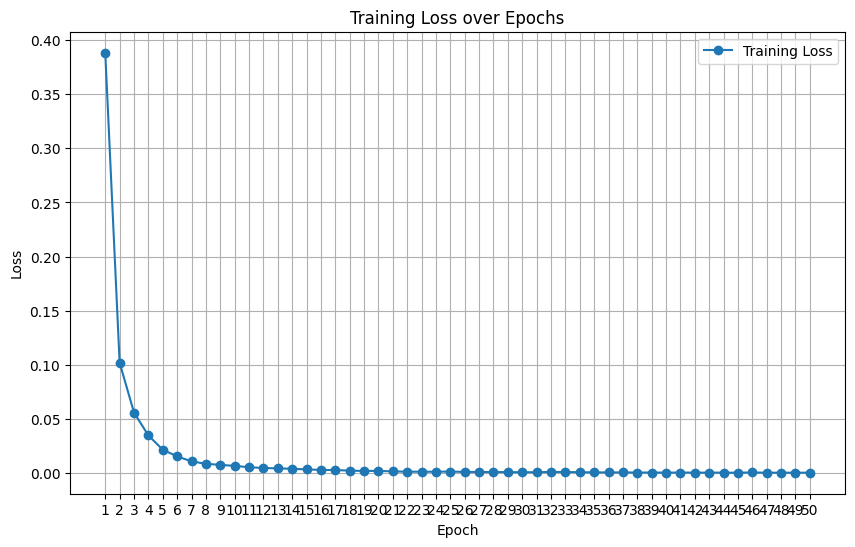

In [9]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(epoch_losses) + 1))  # Set x-axis to show each epoch
plt.legend()
plt.grid()
plt.show()

This plot illustrates the **training loss over epochs**. It shows a rapid and significant decrease in loss during the initial epochs, demonstrating that the model is quickly learning and improving. By the later epochs, the model reaches a very low loss, indicating excellent convergence and strong performance.

In [10]:
# Define the folder where the model should be saved
save_folder = "./model"

# Check if the folder exists
if not os.path.exists(save_folder):
    print(f"Creating folder: {save_folder}")
    os.makedirs(save_folder)
else:
    print(f"Saving model into existing folder: {save_folder}")

# Save the model
model.save_pretrained(save_folder)

print(f"Model and tokenizer saved in: {save_folder}")

Saving model into existing folder: ./model
Model and tokenizer saved in: ./model
